In [2]:
!pip install lightning-utilities

In [3]:
!pip install torchmetrics --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 52.9 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanMetric, Accuracy
from torchmetrics import ConfusionMatrix, Accuracy, Precision, Recall, F1Score

In [5]:
device = "cuda" if torch.cuda.is_available() \
          else "mps" if torch.mps.is_available() \
          else "cpu"
print("Device", device)

Device cuda


In [6]:
!pip install -q kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beriab","key":"dc7d1dc2897c34bbd9f32d0af396a001"}'}

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!ls

kaggle.json  sample_data


In [10]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
  0% 0.00/105M [00:00<?, ?B/s]
100% 105M/105M [00:00<00:00, 1.32GB/s]


In [11]:
!unzip cifake-real-and-ai-generated-synthetic-images.zip -d cifake_data/

Streaming output truncated to the last 5000 lines.
  inflating: cifake_data/train/REAL/4500 (10).jpg  
  inflating: cifake_data/train/REAL/4500 (2).jpg  
  inflating: cifake_data/train/REAL/4500 (3).jpg  
  inflating: cifake_data/train/REAL/4500 (4).jpg  
  inflating: cifake_data/train/REAL/4500 (5).jpg  
  inflating: cifake_data/train/REAL/4500 (6).jpg  
  inflating: cifake_data/train/REAL/4500 (7).jpg  
  inflating: cifake_data/train/REAL/4500 (8).jpg  
  inflating: cifake_data/train/REAL/4500 (9).jpg  
  inflating: cifake_data/train/REAL/4500.jpg  
  inflating: cifake_data/train/REAL/4501 (10).jpg  
  inflating: cifake_data/train/REAL/4501 (2).jpg  
  inflating: cifake_data/train/REAL/4501 (3).jpg  
  inflating: cifake_data/train/REAL/4501 (4).jpg  
  inflating: cifake_data/train/REAL/4501 (5).jpg  
  inflating: cifake_data/train/REAL/4501 (6).jpg  
  inflating: cifake_data/train/REAL/4501 (7).jpg  
  inflating: cifake_data/train/REAL/4501 (8).jpg  
  inflating: cifake_data/train/RE

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),  # Convert images to tensors
     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [37]:
!ls

cifake_data					   kaggle.json
cifake-real-and-ai-generated-synthetic-images.zip  sample_data


In [38]:
!ls cifake_data/

test  train


In [39]:
!ls cifake_data/train
!ls cifake_data/test

FAKE  REAL
FAKE  REAL


In [43]:
import pandas as pd
from IPython.display import display

# data for table
data = {
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'Total Images': [100000, 20000, 20000, 140000],
    'REAL Class': [50000, 10000, 10000, 70000],
    'FAKE Class': [50000, 10000, 10000, 70000]
}

df = pd.DataFrame(data)

# Display the DataFrame as table
display(df.style.background_gradient(cmap='Blues'))

,Split,Total Images,REAL Class,FAKE Class
0,Train,100000,50000,50000
1,Validation,20000,10000,10000
2,Test,20000,10000,10000
3,Total,140000,70000,70000


In [44]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

In [45]:
# defining paths to the train and test datasets
train_dir = 'cifake_data/train'
test_dir = 'cifake_data/test'

In [46]:
# creates datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

In [47]:
train_size = int(0.8 * len(train_dataset)) #80% for training
val_size = len(train_dataset) - train_size #remaining 20% for validation
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [48]:
num_folds = 5 # Number of folds for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [49]:
# Create data loaders for this fold
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

In [50]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler, shuffle=False)

In [51]:
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_dataset)}")

total_images = len(train_data) + len(val_data) + len(test_dataset)
print(f"Total images in dataset: {total_images}")

Training data size: 80000
Validation data size: 20000
Test data size: 20000
Total images in dataset: 120000


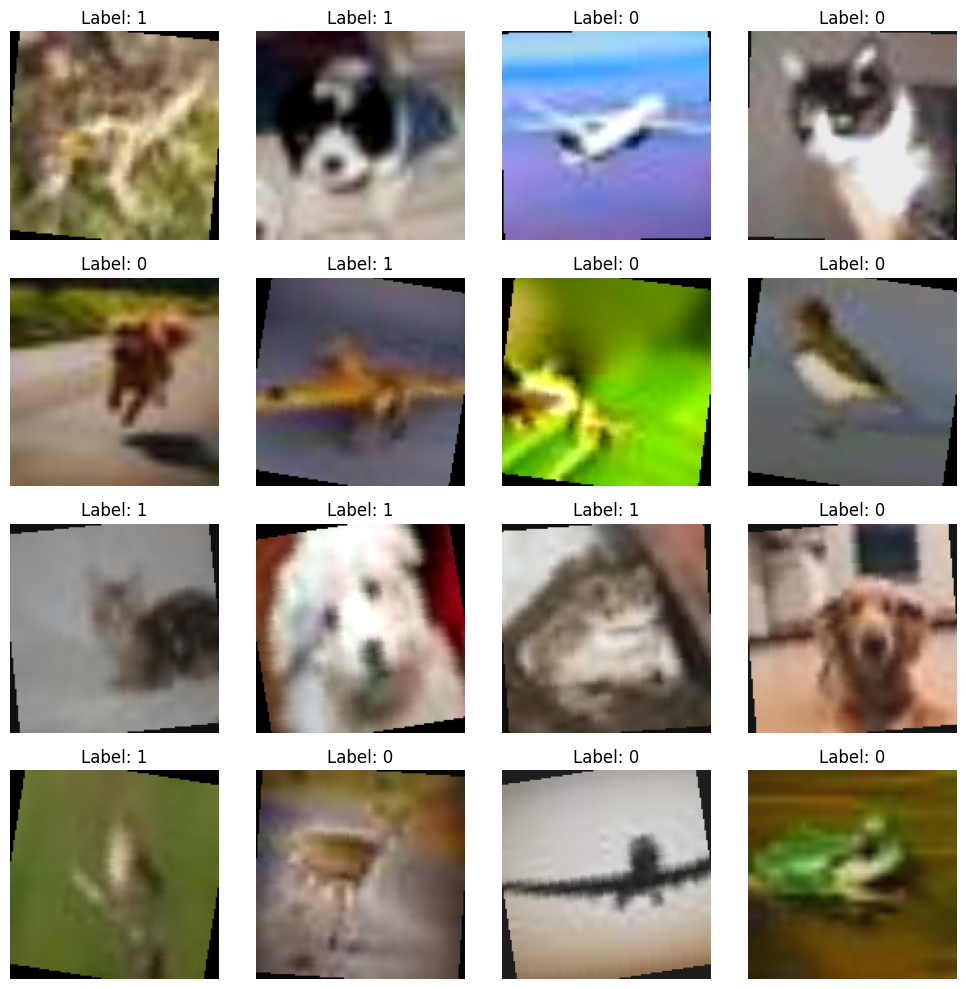

In [54]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

# reverse the normalization
unnormalized_images = images * 0.5 + 0.5

# display the images
plt.figure(figsize=(10, 10))
for i in range(min(len(unnormalized_images), 16)): # show up to 16 images
    plt.subplot(4, 4, i + 1)

    img = unnormalized_images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [55]:
print(train_dataset.class_to_idx)

{'FAKE': 0, 'REAL': 1}


In [56]:
# binary classification (REAL vs FAKE)

In [57]:
import torchvision.models as models # import the module

In [58]:
#first using ResNet18

In [59]:
model = models.resnet18(pretrained=True) #defines model
for param in model.layer4.parameters():
  param.requires_grad = True
for param in model.fc.parameters():
  param.requires_grad = True
model.fc = nn.Linear(model.fc.in_features, 2)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [60]:
model = model.to(device)

In [189]:
import torch.optim as optim # loss function and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [62]:
def train_one_epoch():
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=2).to(device)
    model.train()
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = criteria(preds, Y)
        loss.backward()
        optimizer.step()
        preds = preds.argmax(dim=1)
        losses.update(loss, X.size(0))
        acc.update(preds, Y)
    return losses.compute().item(), acc.compute().item()

In [63]:
def validation_one_epoch():
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=2).to(device)
    model.eval()
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            preds = model(X)
            loss = criteria(preds, Y)
            preds = preds.argmax(dim=1)
            losses.update(loss, X.size(0))
            acc.update(preds, Y)
    return losses.compute().item(), acc.compute().item()

In [64]:
epochs = 5
for i in range(epochs):
    train_loss, train_acc = train_one_epoch()
    val_loss, val_acc = validation_one_epoch()
    print("Epoch:", i, "| Train Loss:", train_loss, "| Train Accuracy", train_acc,
        "| Validation Loss:", val_loss, "| Validation Accuracy:", val_acc)

Epoch: 0 | Train Loss: 0.21399179100990295 | Train Accuracy 0.9150000214576721 | Validation Loss: 0.11964204162359238 | Validation Accuracy: 0.9538499712944031
Epoch: 1 | Train Loss: 0.12873047590255737 | Train Accuracy 0.9517375230789185 | Validation Loss: 0.09655382484197617 | Validation Accuracy: 0.964900016784668
Epoch: 2 | Train Loss: 0.1010332703590393 | Train Accuracy 0.9630749821662903 | Validation Loss: 0.07660716027021408 | Validation Accuracy: 0.9711999893188477
Epoch: 3 | Train Loss: 0.08604850620031357 | Train Accuracy 0.9684500098228455 | Validation Loss: 0.08063498884439468 | Validation Accuracy: 0.9716500043869019
Epoch: 4 | Train Loss: 0.07064393907785416 | Train Accuracy 0.974049985408783 | Validation Loss: 0.06547391414642334 | Validation Accuracy: 0.9764000177383423


In [65]:
test_confusion_matrix = ConfusionMatrix(task= "multiclass", num_classes=2)
test_acc = Accuracy(task='multiclass', num_classes=2)

In [66]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [67]:
model = model.to('cpu')
model.eval()
with torch.no_grad():
  for X, Y in test_loader:
    preds = model(X)
    preds = preds.argmax(dim=1)
    test_confusion_matrix.update(preds, Y)
    test_acc.update(preds, Y)

In [113]:
print("Test Confusion Matrix:\n", test_confusion_matrix.compute())
print("Test Accuracy:", test_acc.compute().item())

Test Confusion Matrix:
 tensor([[9830,  170],
        [ 284, 9716]])
Test Accuracy: 0.9772999882698059


In [112]:
cm = torch.tensor([[9830, 170],
                   [284, 9716]])

TP = cm[1,1].item()
TN = cm[0,0].item()
FP = cm[0,1].item()
FN = cm[1,0].item()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.9773
Precision: 0.9828
Recall: 0.9716
F1 Score: 0.9772


In [114]:
classes = ["FAKE", "REAL"]

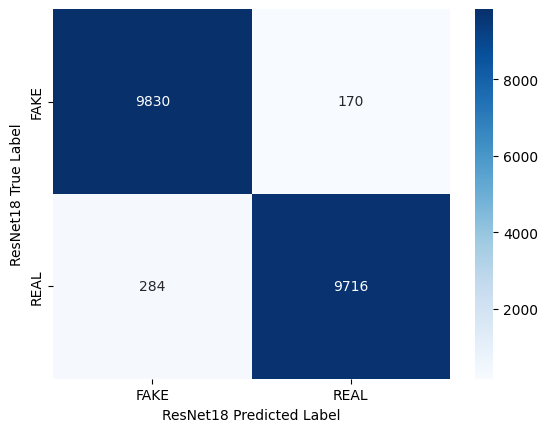

In [115]:
sns.heatmap(test_confusion_matrix.compute(), annot=True, fmt="d",
            cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("ResNet18 Predicted Label")
plt.ylabel("ResNet18 True Label")
plt.show()

In [71]:
test_precision = Precision(task='multiclass', num_classes=2).to(device)

In [72]:
model = model.to(device)

In [73]:
model.eval()
with torch.no_grad():
  for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X)
    preds = preds.argmax(dim=1)
    test_precision.update(preds, Y)

print("Test Precision (ResNet18):", test_precision.compute().item())

Test Precision (ResNet18): 0.9772999882698059


In [74]:
test_recall = Recall(task='multiclass', num_classes=2).to(device)

In [75]:
model = model.to(device)

In [76]:
model.eval()
with torch.no_grad():
  for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X)
    preds = preds.argmax(dim=1)
    test_recall.update(preds, Y)

print("Test Recall (ResNet18):", test_recall.compute().item())

Test Recall (ResNet18): 0.9772999882698059


In [77]:
test_f1 = F1Score(task='multiclass', num_classes=2).to(device)

In [78]:
model = model.to(device)
model.eval()
with torch.no_grad():
  for X, Y in test_loader:
    X = X.to(device)
    Y = Y.to(device)
    preds = model(X)
    preds = preds.argmax(dim=1)
    test_f1.update(preds, Y)

print("Test F1 Score (ResNet18):", test_f1.compute().item())

Test F1 Score (ResNet18): 0.9772999882698059


In [79]:
resnet_metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score (ResNet18)': [test_acc.compute().item(), test_precision.compute().item(), test_recall.compute().item(), test_f1.compute().item()]
}

resnet_results = pd.DataFrame(resnet_metrics)

display(resnet_results.style.background_gradient(cmap='Blues'))

,Metric,Score (ResNet18)
0,Accuracy,0.977300
1,Precision,0.977300
2,Recall,0.977300
3,F1 Score,0.977300


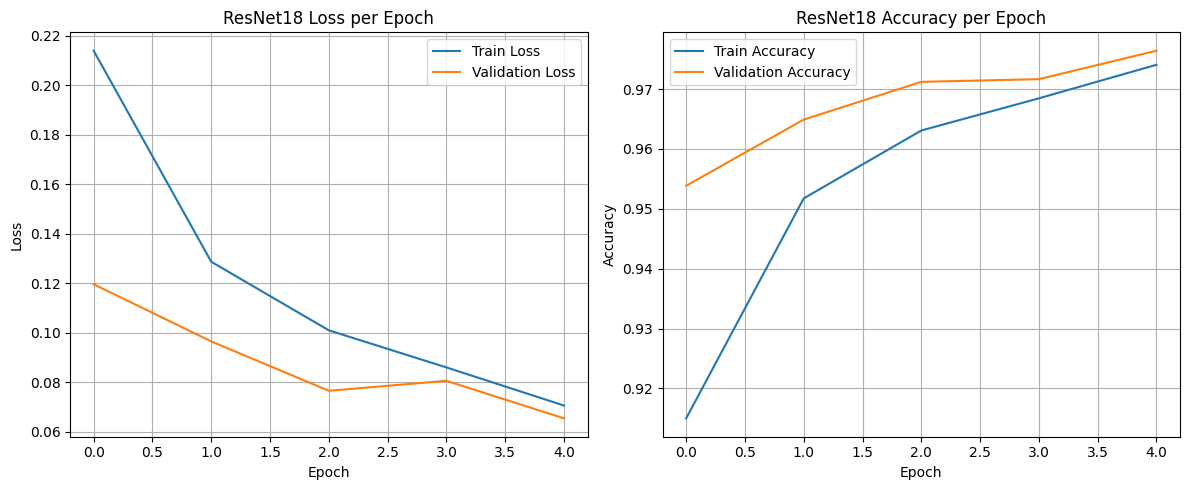

In [148]:
# makin lists to store loss and accuracy values for ResNet18 (based on 5 epochs)
resnet_train_losses = [0.21399179100990295, 0.12873047590255737, 0.1010332703590393, 0.08604850620031357, 0.07064393907785416]
resnet_val_losses = [0.11964204162359238, 0.09655382484197617, 0.07660716027021408, 0.08063498884439468, 0.06547391414642334]
resnet_train_accs = [0.9150000214576721, 0.9517375230789185, 0.9630749821662903, 0.9684500098228455, 0.974049985408783]
resnet_val_accs = [0.9538499712944031, 0.964900016784668, 0.9711999893188477, 0.9716500043869019, 0.9764000177383423]

epochs_resnet = 5

plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs_resnet), resnet_train_losses, label='Train Loss')
plt.plot(range(epochs_resnet), resnet_val_losses, label='Validation Loss')
plt.title('ResNet18 Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs_resnet), resnet_train_accs, label='Train Accuracy')
plt.plot(range(epochs_resnet), resnet_val_accs, label='Validation Accuracy')
plt.title('ResNet18 Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [104]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [80]:
torch.save(model.state_dict(), "resnet_deepfake.pth")

In [81]:
#using custom cnn

In [82]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [83]:
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold + 1}/{num_folds}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [84]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [85]:
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler, shuffle=False)
val_loader = DataLoader(train_dataset, batch_size=16, sampler=val_sampler, shuffle=False)

In [86]:
custom_cnn = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(32), #normalisation of batch
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64), #normalisation of batch
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128), #normalisation of batch
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.LazyLinear(512),
    nn.ReLU(),
    nn.LazyLinear(256),
    nn.ReLU(),
    nn.LazyLinear(2),
)

In [87]:
custom_cnn = custom_cnn.to(device)

In [88]:
criteria = torch.nn.CrossEntropyLoss()

In [89]:
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=0.001)  # Adam optimizer

In [90]:
def train_one_epochcnn():
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=2).to(device)
    custom_cnn.train()
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)
        optimizer.zero_grad()
        preds = custom_cnn(X)
        loss = criteria(preds, Y)
        loss.backward()
        optimizer.step()
        preds = preds.argmax(dim=1)
        losses.update(loss, X.size(0))
        acc.update(preds, Y)
    return losses.compute().item(), acc.compute().item()

In [91]:
def validation_one_epochcnn():
    losses = MeanMetric().to(device)
    acc = Accuracy(task='multiclass', num_classes=2).to(device)
    custom_cnn.eval()
    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            preds = custom_cnn(X)
            loss = criteria(preds, Y)
            preds = preds.argmax(dim=1)
            losses.update(loss, X.size(0))
            acc.update(preds, Y)
    return losses.compute().item(), acc.compute().item()

In [92]:
epochs = 10
for i in range(epochs):
    train_loss, train_acc = train_one_epochcnn()
    val_loss, val_acc = validation_one_epochcnn()
    print("Epoch:", i, "| Train Loss:", train_loss, "| Train Accuracy", train_acc,
        "| Validation Loss:", val_loss, "| Validation Accuracy:", val_acc)

Epoch: 0 | Train Loss: 0.3499657213687897 | Train Accuracy 0.8473250269889832 | Validation Loss: 0.22880619764328003 | Validation Accuracy: 0.9079499840736389
Epoch: 1 | Train Loss: 0.22279125452041626 | Train Accuracy 0.9113374948501587 | Validation Loss: 0.18812929093837738 | Validation Accuracy: 0.9293500185012817
Epoch: 2 | Train Loss: 0.18999174237251282 | Train Accuracy 0.927049994468689 | Validation Loss: 0.16871584951877594 | Validation Accuracy: 0.9362000226974487
Epoch: 3 | Train Loss: 0.16671104729175568 | Train Accuracy 0.9366875290870667 | Validation Loss: 0.15879391133785248 | Validation Accuracy: 0.9432500004768372
Epoch: 4 | Train Loss: 0.1491442620754242 | Train Accuracy 0.9434249997138977 | Validation Loss: 0.16631744801998138 | Validation Accuracy: 0.9326500296592712
Epoch: 5 | Train Loss: 0.1360577940940857 | Train Accuracy 0.9484875202178955 | Validation Loss: 0.14607253670692444 | Validation Accuracy: 0.9417499899864197
Epoch: 6 | Train Loss: 0.12645989656448364 |

In [122]:
test_confusionmatrix = ConfusionMatrix(task= "multiclass", num_classes=2)
test_accuracy = Accuracy(task='multiclass', num_classes=2)

In [123]:
custom_cnn = custom_cnn.to('cpu')
custom_cnn.eval()
with torch.no_grad():
  for X, Y in test_loader:
    preds = custom_cnn(X)
    preds = preds.argmax(dim=1)
    test_confusionmatrix.update(preds, Y)
    test_accuracy.update(preds, Y)

In [124]:
print("Test Confusion Matrix:\n", test_confusionmatrix.compute())
print("Test Accuracy:", test_accuracy.compute().item())

Test Confusion Matrix:
 tensor([[9521,  479],
        [ 511, 9489]])
Test Accuracy: 0.9505000114440918


In [182]:
# confusion matrix values
TN = 9521
FP = 479
FN = 511
TP = 9489

# metrics calculations
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Accuracy: 0.9505
Precision: 0.9519
Recall: 0.9489
F1 Score: 0.9504


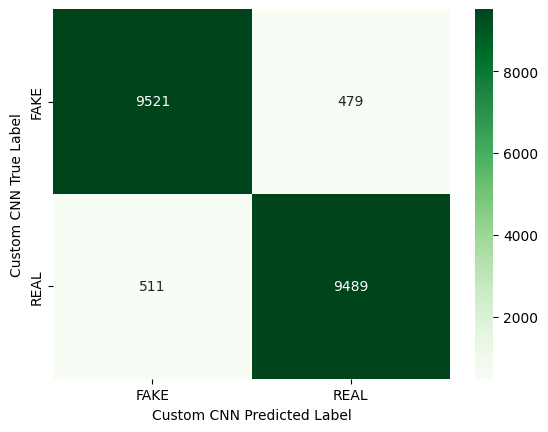

In [188]:
classes = ["FAKE", "REAL"]

sns.heatmap(test_confusionmatrix.compute(), annot=True, fmt="d",
            cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Custom CNN Predicted Label")
plt.ylabel("Custom CNN True Label")
plt.show()

In [ ]:
#epoch analysis

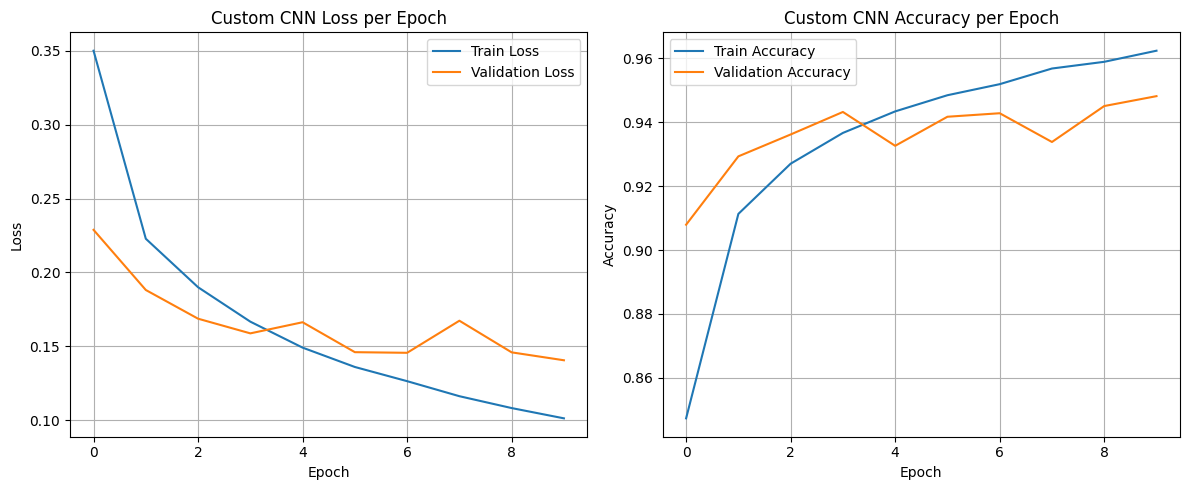

In [184]:
# lists to store the loss & accuracy values from epochs = 10
cnn_train_losses = [0.3499657213687897, 0.22279125452041626, 0.18999174237251282, 0.16671104729175568, 0.1491442620754242, 0.1360577940940857, 0.12645989656448364, 0.1162945032119751, 0.10826780647039413, 0.10132195800542831]
cnn_val_losses = [0.22880619764328003, 0.18812929093837738, 0.16871584951877594, 0.15879391133785248, 0.16631744801998138, 0.14607253670692444, 0.14564725756645203, 0.16734977066516876, 0.1459512561559677, 0.14059923589229584]
cnn_train_accs = [0.8473250269889832, 0.9113374948501587, 0.927049994468689, 0.9366875290870667, 0.9434249997138977, 0.9484875202178955, 0.9519500136375427, 0.956849992275238, 0.9589499831199646, 0.9624249935150146]
cnn_val_accs = [0.9079499840736389, 0.9293500185012817, 0.9362000226974487, 0.9432500004768372, 0.9326500296592712, 0.9417499899864197, 0.9428499937057495, 0.9338499903678894, 0.9451000094413757, 0.948199987411499]

plt.figure(figsize=(12, 5))

# plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), cnn_train_losses, label='Train Loss')
plt.plot(range(epochs), cnn_val_losses, label='Validation Loss')
plt.title('Custom CNN Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), cnn_train_accs, label='Train Accuracy')
plt.plot(range(epochs), cnn_val_accs, label='Validation Accuracy')
plt.title('Custom CNN Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [127]:
import pandas as pd
from IPython.display import display

data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'ResNet18': [0.9773, 0.9828, 0.9716, 0.9772],
    'Custom CNN': [0.9505, 0.9519, 0.9489, 0.9504]
}

comparison_df = pd.DataFrame(data)

display(comparison_df.style.background_gradient(cmap='Blues'))

,Metric,ResNet18,Custom CNN
0,Accuracy,0.977300,0.950500
1,Precision,0.982800,0.951900
2,Recall,0.971600,0.948900
3,F1 Score,0.977200,0.950400


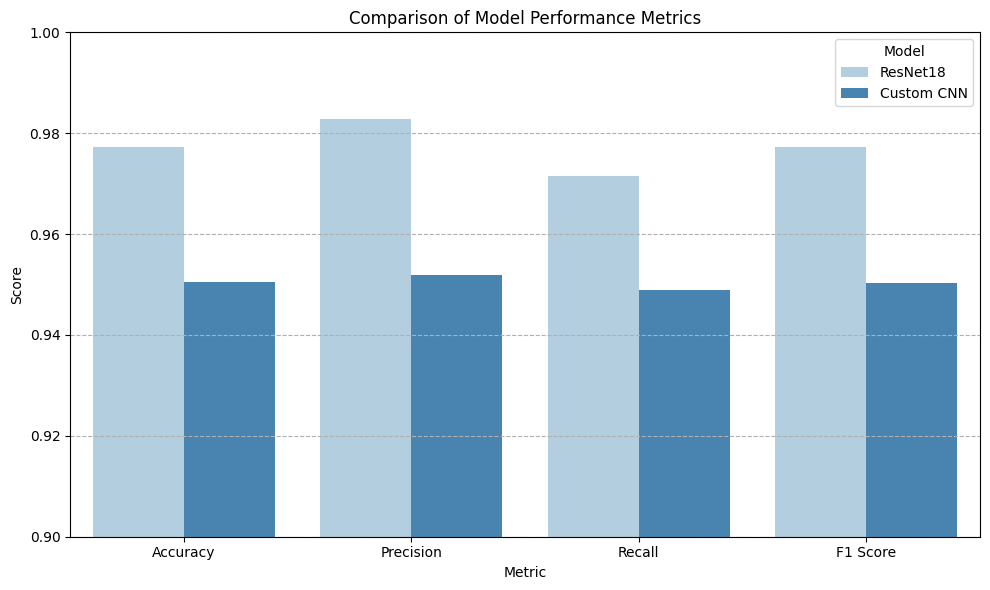

In [141]:
melted_comparison_df = comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=melted_comparison_df, palette='Blues')

plt.title('Comparison of Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0.9, 1.0) #focus on scores
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

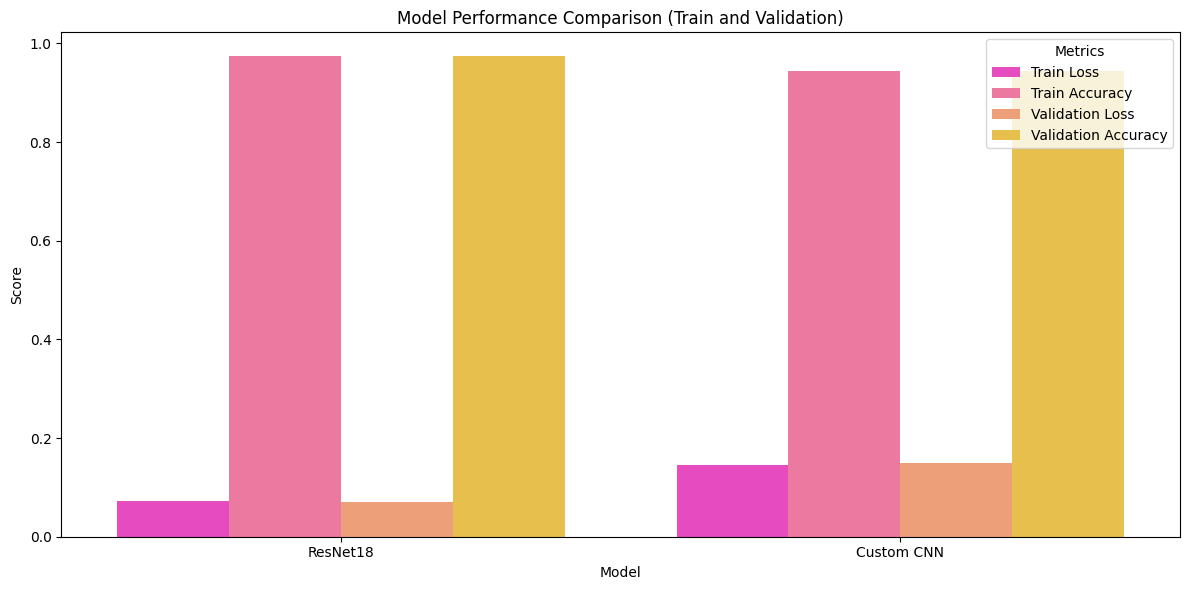

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# create a dictionary with the data
data = {
    'Model': ['ResNet18', 'Custom CNN'],
    'Train Loss': [0.07273107, 0.145690635],
    'Train Accuracy': [0.973787487, 0.943225026],
    'Validation Loss': [0.071199559, 0.148945451],
    'Validation Accuracy': [0.973800004, 0.944949985]
}

# create a Df
results = pd.DataFrame(data)

# melt df
melted_results = results.melt(id_vars='Model', var_name='Metric', value_name='Score')

# barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_results, palette='spring')
plt.title('Model Performance Comparison (Train and Validation)')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

In [135]:
display(results.style.background_gradient(cmap='Pastel1'))

,Model,Train Loss,Train Accuracy,Validation Loss,Validation Accuracy
0,ResNet18,0.072731,0.973787,0.071200,0.973800
1,Custom CNN,0.145691,0.943225,0.148945,0.944950


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

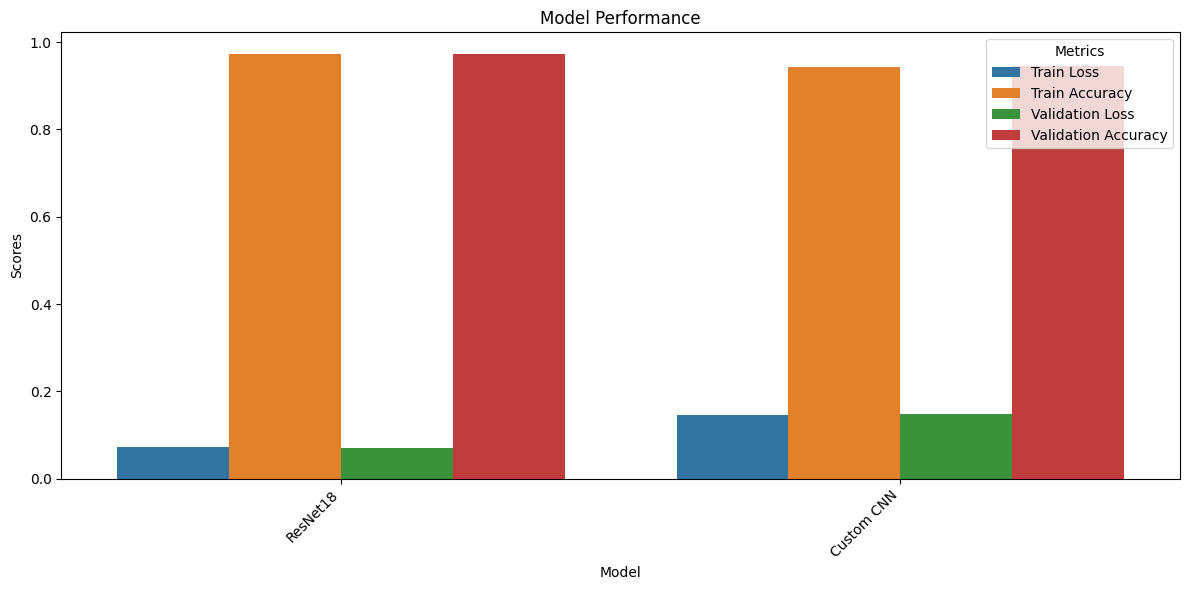

In [103]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(results, ['Model']))
plt.xticks(rotation=45, ha='right')
plt.title('Model Performance')
plt.ylabel('Scores')
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()

In [105]:
data = {
    'Parameter': ['Learning rate', 'Batch size', 'Epochs', 'Optimizer', 'Cross-validation'],
    'ResNet-18': ['0.01 (SGD)', '16', '5', 'SGD', '5-fold'],
    'Custom CNN': ['0.001 (Adam)', '16', '10', 'Adam', '5-fold']
}


hyperparameters_df = pd.DataFrame(data)

display(hyperparameters_df.style.background_gradient(cmap='Pastel1'))

,Parameter,ResNet-18,Custom CNN
0,Learning rate,0.01 (SGD),0.001 (Adam)
1,Batch size,16,16
2,Epochs,5,10
3,Optimizer,SGD,Adam
4,Cross-validation,5-fold,5-fold


In [107]:
print(custom_cnn)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=32768, out_features=512, bias=True)
  (14): ReLU()
  (15): Linear(in_features=512, out_features=256, bias=True)
  (16): ReLU()
  (17): Linear(in_feat

In [ ]:
#see the qualitative

In [165]:
correct_examples = []
incorrect_examples = []
max_examples = 5

In [166]:
custom_cnn = custom_cnn.to('cpu')
custom_cnn.eval()

with torch.no_grad():
    for X, Y in test_loader:
        preds = custom_cnn(X)
        preds = preds.argmax(dim=1)

        for i in range(X.size(0)):
            image = X[i]
            true_label = Y[i].item()
            predicted_label = preds[i].item()

            if predicted_label == true_label:
                if len(correct_examples) < max_examples:
                    correct_examples.append((image, true_label, predicted_label))
            else:
                if len(incorrect_examples) < max_examples:
                    incorrect_examples.append((image, true_label, predicted_label))

            if len(correct_examples) >= max_examples and len(incorrect_examples) >= max_examples:
                break # stop once eenough examples

Correctly Classified CNN Examples:


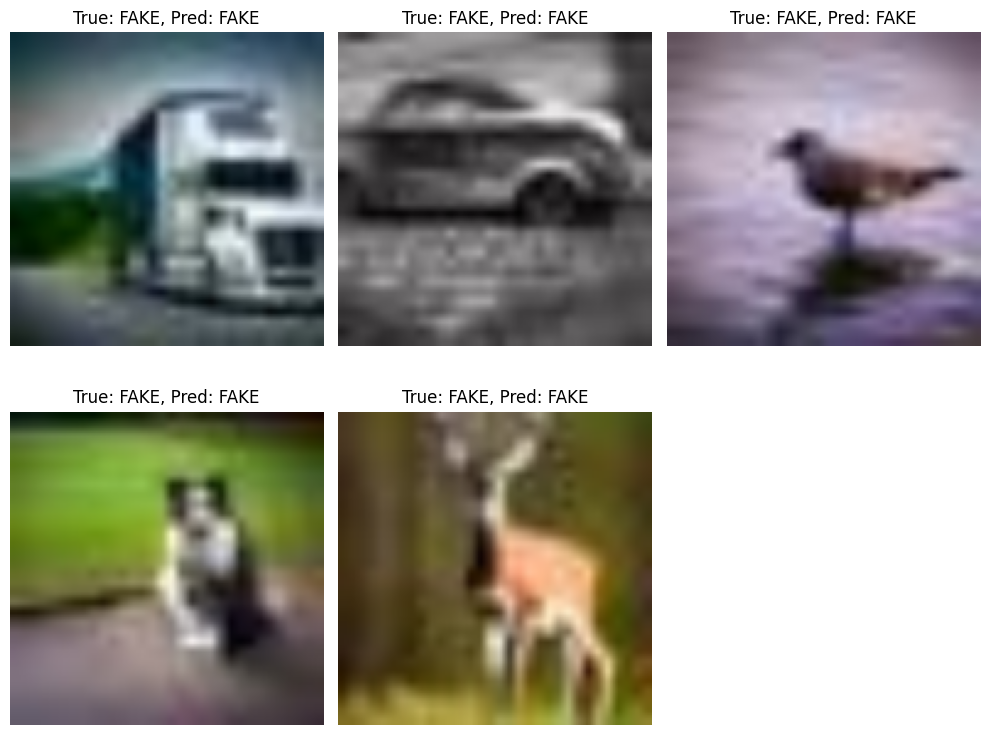

In [180]:
# show correctly classified
print("Correctly Classified CNN Examples:")
plt.figure(figsize=(10, 8))
rows = 2
cols = 3
for i, (image, true_label, predicted_label) in enumerate(correct_examples):
    if i >= rows * cols:
        break
    plt.subplot(rows, cols, i + 1)

    img = image.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # reverse normalization for display
    plt.imshow(img)
    plt.title(f"True: {classes[true_label]}, Pred: {classes[predicted_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Incorrectly Classified CNN Examples:


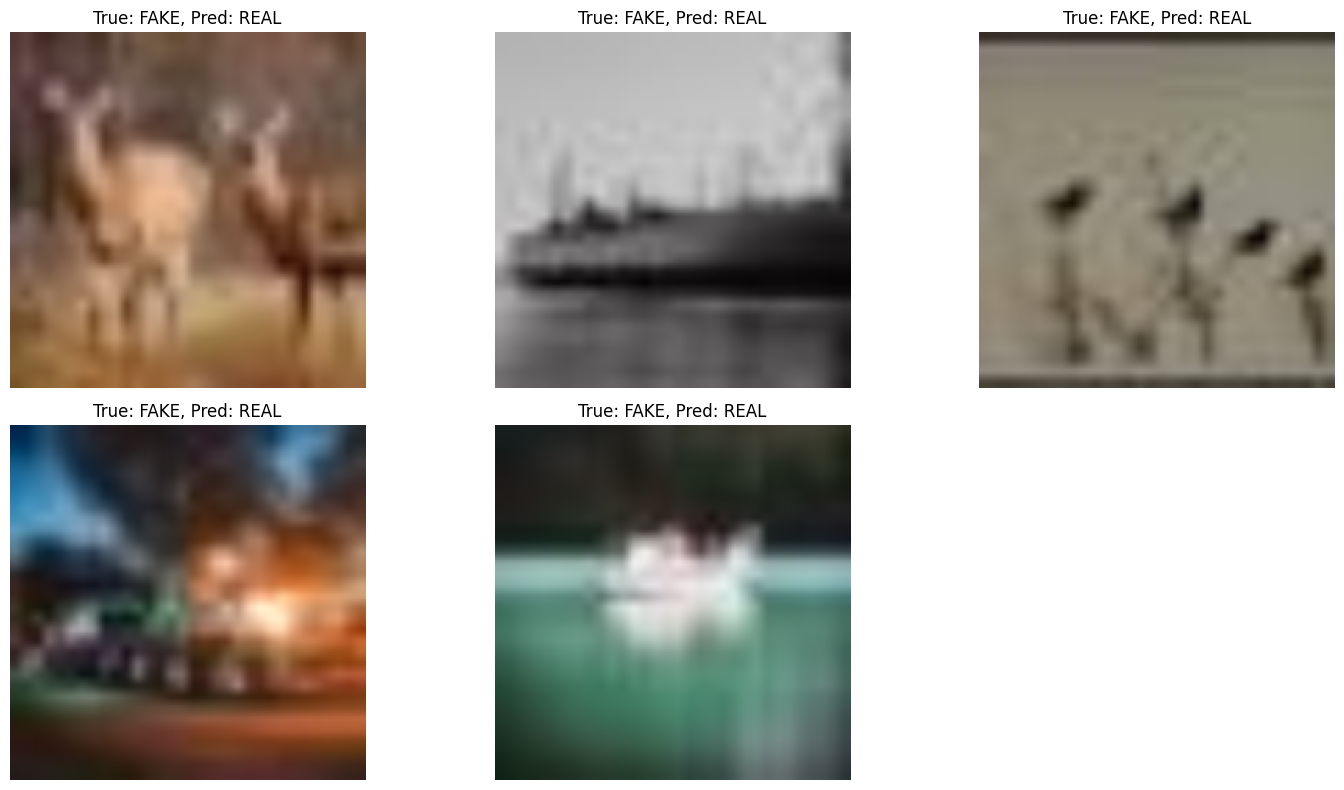

In [187]:
# show incorrectly classified
print("\nIncorrectly Classified CNN Examples:")
plt.figure(figsize=(15, 8)) # Adjust figure size as needed
rows = 2
cols = 3
for i, (image, true_label, predicted_label) in enumerate(incorrect_examples):
    if i >= rows * cols:
        break
    plt.subplot(rows, cols, i + 1)
    img = image.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # reverse normalization for display
    plt.imshow(img)
    plt.title(f"True: {classes[true_label]}, Pred: {classes[predicted_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [169]:
correct_examples_resnet = []
incorrect_examples_resnet = []
max_examples = 5

In [170]:
model = model.to('cpu')
model.eval()

with torch.no_grad():
    for X, Y in test_loader:
        preds = model(X)
        preds = preds.argmax(dim=1)

        for i in range(X.size(0)):
            image = X[i]
            true_label = Y[i].item()
            predicted_label = preds[i].item()

            if predicted_label == true_label:
                if len(correct_examples_resnet) < max_examples:
                    correct_examples_resnet.append((image, true_label, predicted_label))
            else:
                if len(incorrect_examples_resnet) < max_examples:
                    incorrect_examples_resnet.append((image, true_label, predicted_label))

            if len(correct_examples_resnet) >= max_examples and len(incorrect_examples_resnet) >= max_examples:
                break

Correctly Classified Examples (ResNet18):


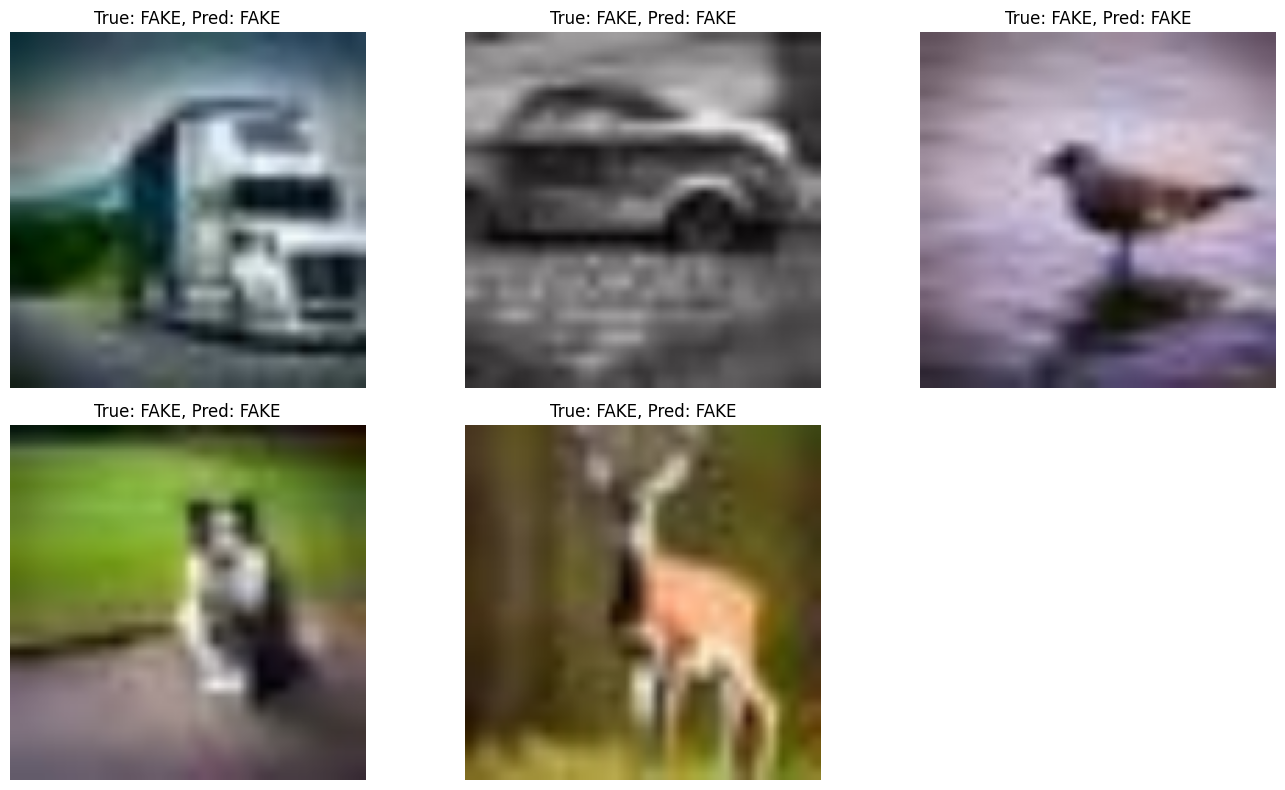

In [186]:
print("Correctly Classified Examples (ResNet18):")
plt.figure(figsize=(14, 8))
cols = 3
for i, (image, true_label, predicted_label) in enumerate(correct_examples_resnet):
    if i >= rows * cols:
        break
    plt.subplot(rows, cols, i + 1)
    img = image.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # reverse normalization for show
    plt.imshow(img)
    plt.title(f"True: {classes[true_label]}, Pred: {classes[predicted_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


Incorrectly Classified Examples (ResNet18):


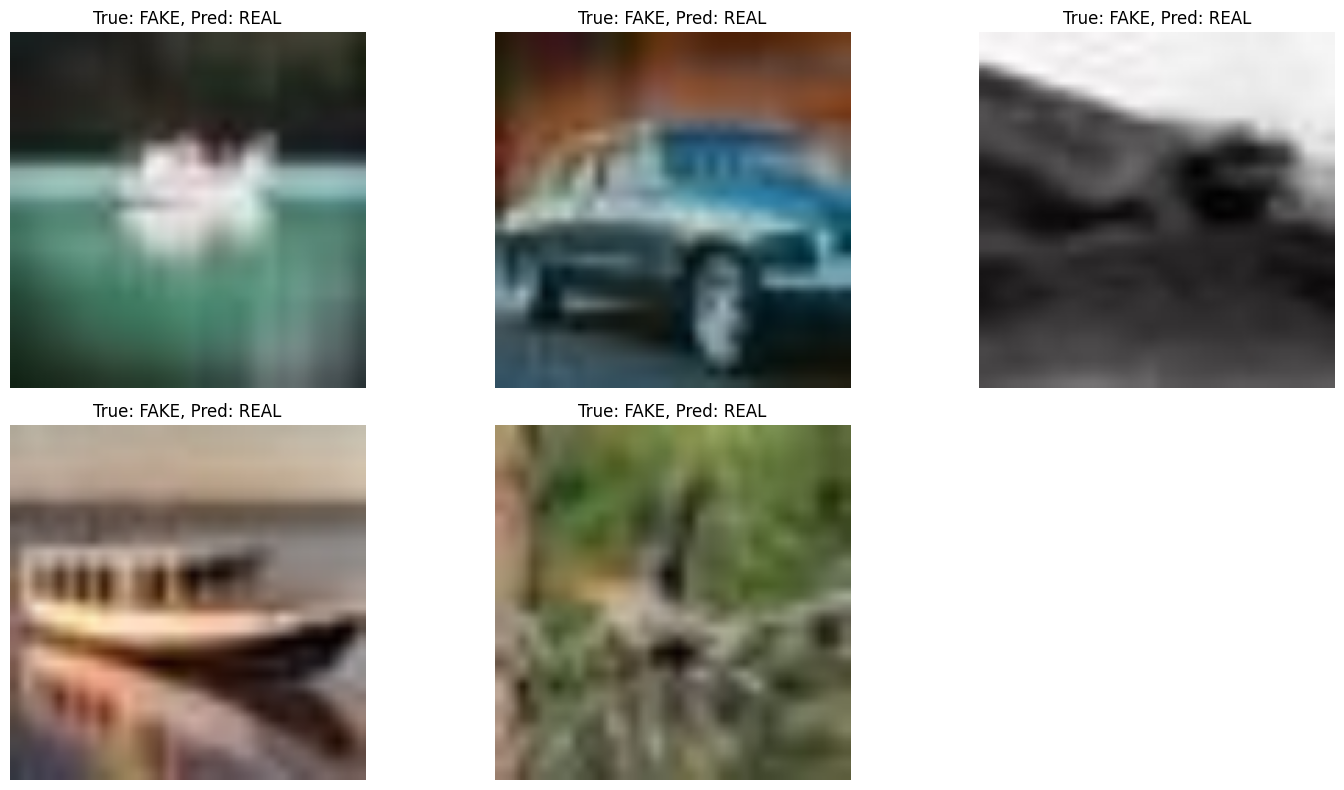

In [185]:
print("\nIncorrectly Classified Examples (ResNet18):")
plt.figure(figsize=(15, 8))
rows = 2
cols = 3
for i, (image, true_label, predicted_label) in enumerate(incorrect_examples_resnet):
    if i >= rows * cols:
        break
    plt.subplot(rows, cols, i + 1)
    img = image.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # reversing normalization for show
    plt.imshow(img)
    plt.title(f"True: {classes[true_label]}, Pred: {classes[predicted_label]}")
    plt.axis('off')
plt.tight_layout()
plt.show()